In [69]:
import classy
import camb
from astropy.cosmology import Planck15 as Planck
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import hmf
from scipy.interpolate import InterpolatedUnivariateSpline as spline

def perc_err(x, y):
    return 100 * np.abs(x - y) / ((x + y) / 2)

def perc_err_plot(**kwargs):
    default_kwargs = {
        'figsize': (8,7),
        'gridspec_kw': {
            'height_ratios':[3,1],
            'hspace': 0.05
        }
    }
    default_kwargs.update(kwargs)
    return plt.subplots(2,1, **default_kwargs)


# Comsology params

In [70]:
h = Planck.h
cosmo = Planck
class LCDM:
    h=h
    H0=Planck.H0.value
    omega_b=Planck.Ob0 * h**2
    omega_cdm=(Planck.Om0 - Planck.Ob0) * h**2
    omega_k=Planck.Ok0
    Neff=Planck.Neff
    Tcmb=Planck.Tcmb0.value
    A_s = 2.097e-9
    tau_reio = 0.0540
    n_s = 0.9652

lnk = np.linspace(-10, 1, 100)
ks = np.exp(lnk)

### Camb Init

In [71]:
camb_params = camb.CAMBparams()
camb_params.set_cosmology(
    H0=LCDM.H0, ombh2=LCDM.omega_b, omch2=LCDM.omega_cdm,
    omk=LCDM.omega_k, nnu=LCDM.Neff, TCMB=LCDM.Tcmb
);
camb_params.WantTransfer = True
camb_params.InitPower.set_params(ns=LCDM.n_s, As=LCDM.A_s);

camb_trans = camb.get_transfer_functions(camb_params)
camb_trans = camb_trans.get_matter_transfer_data().transfer_data[[0,6],:,0] # Returns [k, T_tot(k)]



### CLASS Init

In [112]:
class_params = {
    'h': LCDM.h,
    'omega_b': LCDM.omega_b,
    'omega_cdm': LCDM.omega_cdm,
    'Omega_k': LCDM.omega_k,
    'N_ur': LCDM.Neff,
    'A_s': LCDM.A_s,
    'n_s': LCDM.n_s,
    'T_cmb': LCDM.Tcmb,
    'P_k_max_1/Mpc': 100,
    'output': 'dTk,mPk'
}
cl = classy.Class()
cl.set(class_params)
cl.compute()

### Comparing with HMF CAMB transfer model

In [73]:
camb_tmodel = hmf.transfer_models.CAMB(Planck, camb_params=camb_params)
lnk,lnt = np.log(camb_trans)
lnt_model = camb_tmodel.lnt(lnk)

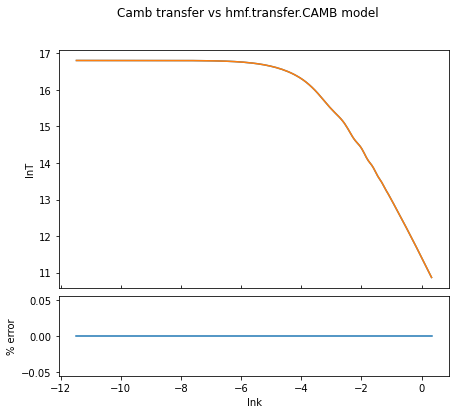

In [74]:
fig, ax = plt.subplots(
    2,1, figsize=(7,6),
    gridspec_kw={'height_ratios': [3,1], 'hspace': 0.05}
)

a = ax[0]
a.plot(lnk, lnt)
a.plot(lnk, lnt_model)
a.set_ylabel('lnT')
a.tick_params(axis='x', which='both', direction='in',labelbottom=False)

a = ax[1]
a.plot(lnk, perc_err(lnt, lnt_model))
a.set(xlabel='lnk', ylabel='% error')

fig.suptitle("Camb transfer vs hmf.transfer.CAMB model")
plt.show()

## Comparing CAMB pk with HMF pk

In [75]:
nonlinear=False
z = 0
mf = hmf.hmf.MassFunction(
    cosmo_model=Planck, transfer_params={'camb_params': camb_params},
    z=z
)
camb_pk = camb.get_matter_power_interpolator(
    camb_params, nonlinear=nonlinear, 
)
# Calculates power
mf.power;

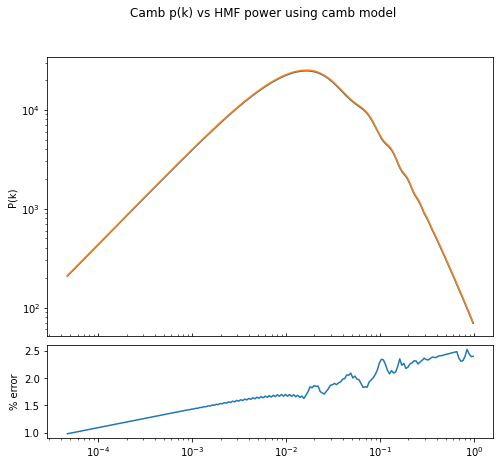

In [76]:
fig, (ax1, ax2) = plt.subplots(
    2,1, 
    gridspec_kw={'height_ratios': [3,1]},
    figsize=(8,7),
)
plt.subplots_adjust(hspace=0.05)

mask =  mf.k >= ks[0]
mask *= mf.k < ks[-1]
mask *= mf.k < 1

ax1.plot(mf.k[mask], camb_pk.P(z, mf.k[mask])) 
ax1.plot(mf.k[mask], mf.power[mask])
ax1.set(xscale='log', yscale='log', ylabel='P(k)')
ax1.tick_params(axis='x', which='both', direction='in',labelbottom=False)

ax2.plot(mf.k[mask], perc_err(mf.power[mask], camb_pk.P(z, mf.k[mask])))
ax2.set_xscale('log')
ax2.set_ylabel("% error")

fig.suptitle("Camb p(k) vs HMF power using camb model")
fig.patch.set_facecolor('white')
plt.show()

# Class/CAMB transfer comparison

In [77]:
cl_trans = cl.get_transfer(output_format='camb')
cl_trans = np.array([cl_trans['k (h/Mpc)'], cl_trans['-T_tot/k2']])

lnk, lnTcl = np.log(cl_trans)
lnTcm = camb_tmodel.lnt(lnk)

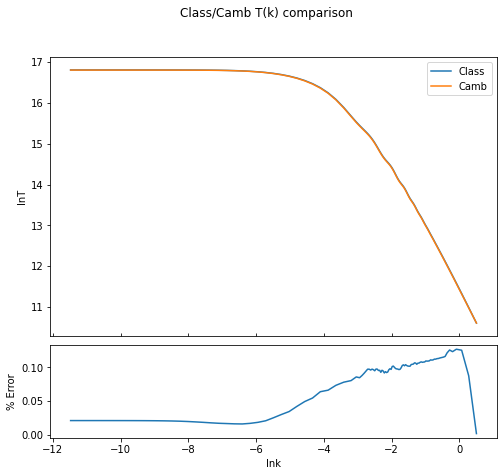

In [78]:
m = lnk < 0.5
x = lnk[m]
y1 = lnTcl[m]
y2 = lnTcm[m]

fig, (ax1, ax2) = perc_err_plot()

ax1.plot(x, y1, label="Class")
ax1.plot(x, y2, label="Camb")
ax1.set(ylabel='lnT')
ax1.tick_params(axis='x', which='both', direction='in',labelbottom=False)
ax1.legend()

ax2.plot(x, perc_err(y1,y2))
ax2.set(xlabel='lnk', ylabel='% Error')

fig.suptitle("Class/Camb T(k) comparison")
fig.patch.set_facecolor('white')
plt.show()

### CLASS/CAMB P(k) comparison

In [79]:
pkinterp = camb.get_matter_power_interpolator(camb_params, nonlinear=False, kmax=ks[-1], zs = [0])

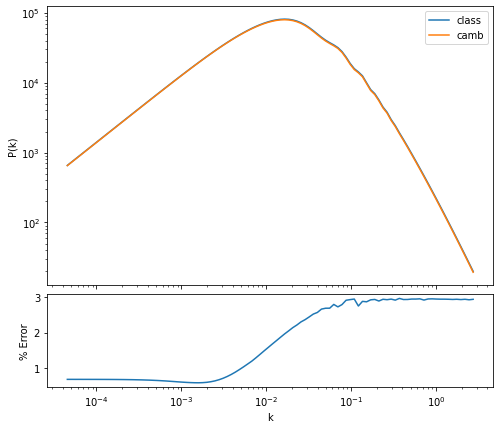

In [113]:
z = 0
x = ks
y1 = np.array([cl.pk(k*h, 0) for k in ks])
y2 = pkinterp.P(z, ks) / h**3

fig, (ax1, ax2) = perc_err_plot()

ax1.plot(x, y1, label='class')
ax1.plot(x, y2, label='camb')
ax1.set(xscale='log', yscale='log')
ax1.set(ylabel='P(k)')
ax1.legend()

ax2.plot(x, perc_err(y1, y2))
ax2.set(xscale='log', xlabel='k', ylabel='% Error')
plt.show()

# Creating Custom transfer component for CLASS

In [39]:
from hmf.transfer_models import CAMB

In [40]:
class CLASS_Transfer(hmf.transfer_models.FromFile):
    """
    Transfer function computed by CLASS. 
    
    Parameters
    ----------
    
    cosmo : :class:`astropy.cosmology.FLRW` instance
        The cosmology used in the calculation

    \*\*model_parameters : unpack-dict
        Parameters specific to this model.

        **class_params:** 
            Dict of params to set for CLASS object
        **class_object:** 
            Custom class object. If not set, a new Class object will be 
            created.
    """
    _defaults = {"class_params": None, "class_obj": None}
    
    def __init__(self, *args, **kwargs):
        super(CLASS_Transfer, self).__init__(*args, **kwargs)
        self.spline_fn = None

        if self.params['class_obj'] is not None:
            self.class_obj = self.params['class_obj']
        else:
            self.class_obj = classy.Class()
            class_params = self.params['class_params']
            if class_params is None:
                class_params = {}
                
            h = self.cosmo.h
            defaults = {
                'omega_b': self.cosmo.Ob0 * h**2, 
                'omega_cdm': (self.cosmo.Om0 - self.cosmo.Ob0) * h**2,
                'h': h,
            }
            for k,v in defaults.items():
                class_params.setdefault(k,v)
            class_params['output'] = 'dTk'            

            self.class_obj.set(class_params)
        
    def lnt(self, lnk):
        if self.spline_fn is None:
            trans = self.class_obj.get_transfer(output_format='camb')
            if not trans:
                self.class_obj.compute()
                trans = self.class_obj.get_transfer(output_format='camb')

            _lnk, _lnt = np.log(trans['k (h/Mpc)']), np.log(trans['-T_tot/k2'])
            if lnk[0] < _lnk[0]:
                _lnk, _lnt = self._check_low_k(_lnk, _lnt, lnk[0])
            self.spline_fn = spline(_lnk, _lnt, k=1)
            
        return self.spline_fn(lnk)

In [41]:
mf = hmf.MassFunction()
lnk = np.log(mf.k)
class_t = CLASS_Transfer(Planck)
camb_t = CAMB(Planck)

clt = class_t.lnt(lnk)
cambt = camb_t.lnt(lnk)

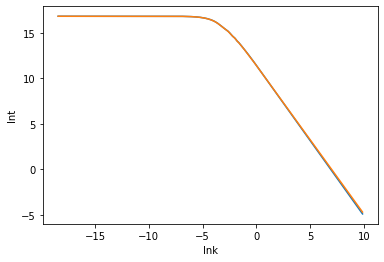

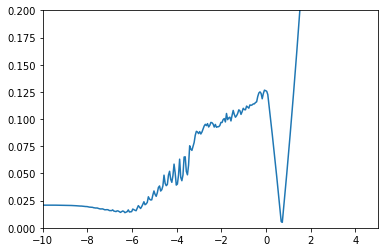

In [42]:
plt.plot(lnk, clt)
plt.plot(lnk, cambt)
plt.xlabel("lnk")
plt.ylabel("lnt")
plt.show()

perc_diff = 100 * np.abs(clt - cambt)/ ((clt + cambt)/2)
plt.plot(lnk, perc_diff)
plt.xlim(-10, 5)
plt.ylim(0, 0.2)
plt.show()

# HMF pk / CLASS pk comparison

In [58]:
Planck.Neff

3.046

In [67]:
cosmo = Planck
h = cosmo.h
class_params = {
    'omega_b': cosmo.Ob0 * h**2, 'omega_cdm': (cosmo.Om0 - cosmo.Ob0) * h**2,
    'h': cosmo.h, 'A_s':2.0975e-9, 'n_s': 0.9652, 'P_k_max_1/Mpc': 100, 'N_ur': Planck.Neff,
    'output': 'dTk,mPk'
}
cl = classy.Class()
cl.set(class_params)
cl.compute()

In [68]:
mf = hmf.hmf.MassFunction(
    transfer_model=CLASS_Transfer,
    transfer_params = {'class_obj': cl},
    cosmo_model=cosmo,
    z=0,
)

In [69]:
mask = mf.k<100
class_pk = np.array([cl.pk(k*h, 0) for k in mf.k[mask]]) * h**3

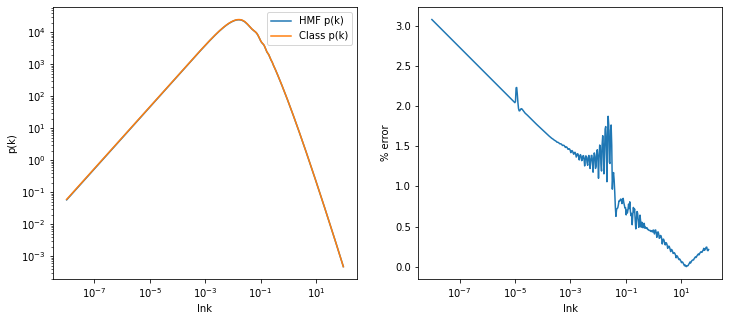

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.patch.set_facecolor('white')

a = ax[0]
a.plot(mf.k[mask], mf.power[mask], label='HMF p(k)')
a.plot(mf.k[mask], class_pk, label='Class p(k)')
a.set_xscale('log')
a.set_yscale('log')
a.set_xlabel('lnk')
a.set_ylabel('p(k)')
a.legend()

diff = mf.power[mask] - class_pk
perc_err = 100*np.abs(diff) / ((mf.power[mask] + class_pk)/2)
a = ax[1]
a.plot(mf.k[mask], perc_err)
a.set_xscale('log')
a.set_xlabel('lnk')
a.set_ylabel('% error')

plt.show()

# Testing CAMB pk vs hmf pk 

In [71]:
camb_params = camb.CAMBparams()
camb_params.set_cosmology(
    H0=Planck.H0.value, ombh2=Planck.Ob0 * h**2, omch2=(Planck.Om0 - Planck.Ob0) * h**2,
    omk = Planck.Ok0, nnu = Planck.Neff, TCMB=Planck.Tcmb0.value
);
camb_params.WantTransfer = True
camb_params.InitPower.set_params(ns=0.9652, As=2.0975e-0)
camb_transfers = camb.get_transfer_functions(camb_params)
camb_trans = camb_transfers.get_matter_transfer_data().transfer_data[[0,6],:,0]

# HMF transfer model
camb_tmodel = hmf.transfer_models.CAMB(Planck, camb_params=camb_params)

In [72]:
class_tmodel = CLASS_Transfer(cosmo, class_obj=cl)

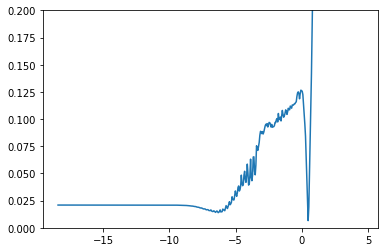

In [73]:
lnk = np.log(mf.k[mf.k < 100])
camb_t = camb_tmodel.lnt(lnk)
class_t = class_tmodel.lnt(lnk)
perc_err = 100 * np.abs(camb_t - class_t) / ((camb_t + class_t) / 2)
plt.ylim(0, 0.2)
plt.plot(lnk, perc_err)